# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer
import math

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

In [472]:
train_X.shape, train_y.shape


9

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [167]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

compar 6.000000000039306 6.0 [6.] [3.] [1.e-05]
Gradient check passed!
compar 0.9999999999621422 1.0 [1. 1.] [3. 2.] [1.e-05 0.e+00]
compar 0.9999999999621422 1.0 [1. 1.] [3. 2.] [0.e+00 1.e-05]
Gradient check passed!
compar 0.9999999999621422 1.0 [[1. 1.]
 [1. 1.]] [[3. 2.]
 [1. 0.]] [[1.e-05 0.e+00]
 [0.e+00 0.e+00]]
compar 0.9999999999621422 1.0 [[1. 1.]
 [1. 1.]] [[3. 2.]
 [1. 0.]] [[0.e+00 1.e-05]
 [0.e+00 0.e+00]]
compar 0.9999999999621422 1.0 [[1. 1.]
 [1. 1.]] [[3. 2.]
 [1. 0.]] [[0.e+00 0.e+00]
 [1.e-05 0.e+00]]
compar 0.9999999999621422 1.0 [[1. 1.]
 [1. 1.]] [[3. 2.]
 [1. 0.]] [[0.e+00 0.e+00]
 [0.e+00 1.e-05]]
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [234]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

[2.06106005e-09 4.53978686e-05 9.99954600e-01]
[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [144]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)


[-1.00067604e+01 -5.00676044e+00 -6.76044355e-03]


15.020281330641362

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [228]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
print(loss, grad)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

predictions [1 0 0] softmax [0.57611688 0.21194156 0.21194156] target [0 1 0] loss 1.551444713932051 grad [ 0.57611688 -0.78805844  0.21194156]
1.551444713932051 [ 0.57611688 -0.78805844  0.21194156]
predictions [1. 0. 0.] softmax [0.57611688 0.21194156 0.21194156] target [0. 1. 0.] loss 1.551444713932051 grad [ 0.57611688 -0.78805844  0.21194156]
predictions [1.00001 0.      0.     ] softmax [0.57611933 0.21194034 0.21194034] target [0. 1. 0.] loss 1.551450475113109 grad [ 0.57611933 -0.78805966  0.21194034]
predictions [0.99999 0.      0.     ] softmax [0.57611444 0.21194278 0.21194278] target [0. 1. 0.] loss 1.5514389527754138 grad [ 0.57611444 -0.78805722  0.21194278]
compar (0,) 0.5761168847651099 0.5761168847658291 [1.e-05 0.e+00 0.e+00]
Gradients are equal at (0,)
predictions [1.e+00 1.e-05 0.e+00] softmax [0.57611566 0.21194323 0.21194111] target [0. 1. 0.] loss 1.5514368333559785 grad [ 0.57611566 -0.78805677  0.21194111]
predictions [ 1.e+00 -1.e-05  0.e+00] softmax [0.576118

True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [529]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print(predictions, target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float).squeeze()
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print(predictions, target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)



[[ 1.  2. -1.  1.]] [[2]]
[[ 0.20603191  0.56005279 -0.97211661  0.20603191]] [[ 1.  2. -1.  1.]]
Gradients are equal at (0, 0)
Gradients are equal at (0, 1)
Gradients are equal at (0, 2)
Gradients are equal at (0, 3)
Gradient check passed!
[[ 2. -1. -1.  1.]
 [ 0.  1.  1.  1.]
 [ 1.  2. -1.  2.]] [[3]
 [3]
 [2]]
[[ 0.22715085  0.01130918  0.01130918 -0.2497692 ]
 [ 0.03641059  0.09897425  0.09897425 -0.23435909]
 [ 0.05072101  0.13787399 -0.32646899  0.13787399]] [[ 2. -1. -1.  1.]
 [ 0.  1.  1.  1.]
 [ 1.  2. -1.  2.]]
Gradients are equal at (0, 0)
Gradients are equal at (0, 1)
Gradients are equal at (0, 2)
Gradients are equal at (0, 3)
Gradients are equal at (1, 0)
Gradients are equal at (1, 1)
Gradients are equal at (1, 2)
Gradients are equal at (1, 3)
Gradients are equal at (2, 0)
Gradients are equal at (2, 1)
Gradients are equal at (2, 2)
Gradients are equal at (2, 3)
Gradient check passed!


True

In [269]:
# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]], dtype="float"))
assert np.all(np.isclose(probs[:, 0], 1.0))

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [528]:
from numpy.linalg import inv
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)
print(X, W, target_index, sep="\n\n")
loss, dW = linear_classifer.linear_softmax(X, W, target_index)

print("loss", loss, "dW", dW)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

[[-1. -1.  1.]
 [ 0.  1.  1.]]

[[ 1.  2.]
 [-1.  1.]
 [ 1.  2.]]

[1 1]
loss 1.0877576813083574 dW [[-0.44039854  0.44039854]
 [-0.4166856   0.4166856 ]
 [ 0.46411148 -0.46411148]]
[[-0.44039854  0.44039854]
 [-0.4166856   0.4166856 ]
 [ 0.46411148 -0.46411148]] [[ 1.  2.]
 [-1.  1.]
 [ 1.  2.]]
Gradients are equal at (0, 0)
Gradients are equal at (0, 1)
Gradients are equal at (1, 0)
Gradients are equal at (1, 1)
Gradients are equal at (2, 0)
Gradients are equal at (2, 1)
Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [526]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

[[ 0.02  0.04]
 [-0.02  0.02]
 [ 0.02  0.04]] [[ 1.  2.]
 [-1.  1.]
 [ 1.  2.]]
Gradients are equal at (0, 0)
Gradients are equal at (0, 1)
Gradients are equal at (1, 0)
Gradients are equal at (1, 1)
Gradients are equal at (2, 0)
Gradients are equal at (2, 1)
Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [521]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e-4)

0.001 0.0001
Epoch 0, loss: 2.302753
Epoch 1, loss: 2.300651
Epoch 2, loss: 2.300163
Epoch 3, loss: 2.300168
Epoch 4, loss: 2.297813
Epoch 5, loss: 2.297042
Epoch 6, loss: 2.295482
Epoch 7, loss: 2.297792
Epoch 8, loss: 2.292672
Epoch 9, loss: 2.298440


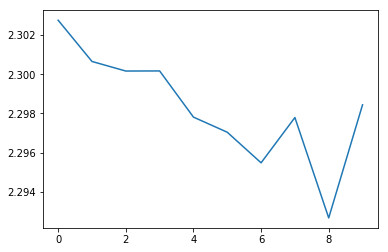

In [522]:
# let's look at the loss history!
plt.plot(loss_history)

In [420]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
#print(pred, val_y)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

Accuracy:  0.1


In [530]:
# Now, let's train more and see if it performs better
classifier = linear_classifer.LinearSoftmaxClassifier()
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e-4)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

0.001 0.0001
Epoch 0, loss: 2.301344
Epoch 1, loss: 2.300707
Epoch 2, loss: 2.301084
Epoch 3, loss: 2.298168
Epoch 4, loss: 2.300187
Epoch 5, loss: 2.299434
Epoch 6, loss: 2.297585
Epoch 7, loss: 2.294682
Epoch 8, loss: 2.291807
Epoch 9, loss: 2.290810
Epoch 10, loss: 2.292781
Epoch 20, loss: 2.284464
Epoch 30, loss: 2.286401
Epoch 40, loss: 2.268246
Epoch 50, loss: 2.260308
Epoch 60, loss: 2.271335
Epoch 70, loss: 2.251913
Epoch 80, loss: 2.250273
Epoch 90, loss: 2.247584
Accuracy after training for 100 epochs:  0.211


### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [457]:
num_epochs = [100, 200]
batch_size = np.arange(10, 200, 5)

learning_rates = [1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5]

import itertools
for lr, rs, bs, ne in itertools.product(learning_rates, reg_strengths, batch_size, num_epochs):
    # Now, let's train more and see if it performs better
    classifier = linear_classifer.LinearSoftmaxClassifier()
    classifier.fit(train_X, train_y, epochs=ne, learning_rate=lr, batch_size=bs, reg=rs)
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    print("Accuracy after training for", num_epochs, "epochs: ", accuracy, 
          "lr", lr, "rs", rs, "bs", bs, "ne", ne)    


best_classifier = None
# 0.131 lr 0.0001 rs 1e-05 bs 100
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.302585, l2_loss 0.000474
Epoch 10, loss: 2.302585, l2_loss 0.000714
Epoch 20, loss: 2.302585, l2_loss 0.000686
Epoch 30, loss: 2.302585, l2_loss 0.000687
Epoch 40, loss: 2.302585, l2_loss 0.000693
Epoch 50, loss: 2.302585, l2_loss 0.000692
Epoch 60, loss: 2.302585, l2_loss 0.000696
Epoch 70, loss: 2.302585, l2_loss 0.000700
Epoch 80, loss: 2.302585, l2_loss 0.000701
Epoch 90, loss: 2.302585, l2_loss 0.000690
Accuracy after training for [100, 200] epochs:  0.049 lr 0.001 rs 0.001 bs 10 ne 100
Epoch 0, loss: 2.302586, l2_loss 0.000506
Epoch 10, loss: 2.302585, l2_loss 0.000684
Epoch 20, loss: 2.302585, l2_loss 0.000669
Epoch 30, loss: 2.302585, l2_loss 0.000715
Epoch 40, loss: 2.302585, l2_loss 0.000698
Epoch 50, loss: 2.302585, l2_loss 0.000717
Epoch 60, loss: 2.302585, l2_loss 0.000692
Epoch 70, loss: 2.302585, l2_loss 0.000686
Epoch 80, loss: 2.302585, l2_loss 0.000695
Epoch 90, loss: 2.302585, l2_loss 0.000694
Epoch 100, loss: 2.302585, l2_loss 0.000691
Epoch 110, lo

KeyboardInterrupt: 

In [519]:
# Now, let's train more and see if it performs better
classifier = linear_classifer.LinearSoftmaxClassifier()
classifier.fit(train_X, train_y, epochs=200, learning_rate=1e-4, batch_size=10, reg=1e-5)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for best classifier: ", accuracy)

0.0001 1e-05
Epoch 0, loss: 2.297273
0.008935082156277353 -0.004469120300453694 1.787073729046885e-07
Epoch 1, loss: 2.313368
0.0172824490870285 -0.007695361093819869 3.4545707619410136e-07
Epoch 2, loss: 2.276900
0.02540685731121432 -0.01082999063356496 5.081533748046863e-07
Epoch 3, loss: 2.285909
0.03331557559080756 -0.013885283482431168 6.657302540263698e-07
Epoch 4, loss: 2.311785
0.04100352489011594 -0.01685566377655194 8.196909777512232e-07
Epoch 5, loss: 2.310030
0.0484893863836556 -0.019746594872452738 9.692165929750336e-07
Epoch 6, loss: 2.282952
0.05577333898178752 -0.022557603000620433 1.1152961275366038e-06
Epoch 7, loss: 2.287400
0.0628564066412171 -0.025292412687857587 1.2571634012807882e-06
Epoch 8, loss: 2.284538
0.06974780915112179 -0.027959518807148014 1.3946010564267616e-06
Epoch 9, loss: 2.296889
0.07645098539427515 -0.03055393862343432 1.5290682829946755e-06
Epoch 10, loss: 2.236445
0.08296290026407524 -0.033076861212845546 1.6585132731124973e-06
Epoch 20, loss: 2

In [466]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV


sgd = SGDClassifier(max_iter=1000, tol=1e-3, penalty='l2', loss="squared_hinge")
parameters = {"eta0" : [1e-4, 1e-5], "alpha" :[1e-4, 1e-5], "learning_rate": ["constant"]}
clf = GridSearchCV(sgd, parameters, cv=3)
clf.fit(train_X, train_y)
print(clf.cv_results_)

#pred = sgd.predict(val_X)
#accuracy = multiclass_accuracy(pred, val_y)
#print("Accuracy after training for SGDClassifier: ", accuracy)

{'mean_fit_time': array([7.13225238, 9.44757811, 7.48033007, 9.94893368]), 'std_fit_time': array([0.79282444, 0.55636562, 0.23355905, 0.19921442]), 'mean_score_time': array([0.01663423, 0.01519513, 0.01652869, 0.01599813]), 'std_score_time': array([0.00244641, 0.00031274, 0.00153408, 0.00035757]), 'param_alpha': masked_array(data=[0.0001, 0.0001, 1e-05, 1e-05],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_eta0': masked_array(data=[0.0001, 1e-05, 0.0001, 1e-05],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=['constant', 'constant', 'constant', 'constant'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'constant'}, {'alpha': 0.0001, 'eta0': 1e-05, 'learning_rate': 'constant'}, {'alpha': 1e-05, 'eta0': 0.0001, 'learning_rate':

# Какой же точности мы добились на тестовых данных?

In [520]:
test_pred = classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.188000
